# Predictions

---

This section loads the models, and get predictions for the validation and test sets (it's possible to get the training as well, but it uses cpu only, so it takes a loooong time).

In [20]:
import torch
from torch.utils.data import DataLoader

import sys
from transformers import (
    ViTForImageClassification,
    AutoConfig
)

import itertools
import pandas as pd
import numpy as np

sys.path.append('..')
from src.chexpert import CheXpertDataset

pathologies = ['Atelectasis',
                'Cardiomegaly',
                'Consolidation',
                'Edema',
                'Pleural Effusion']


def get_predictions(ckpts, approach, data_path, train=False):
    dataset = CheXpertDataset(
                data_path=data_path,
                uncertainty_policy=approach,
                train=train,
                resize_shape=(224, 224))
    dataloader = DataLoader(dataset, batch_size=234, shuffle=False)

    models = []
    for checkpoint in ckpts:
        model = ViTForImageClassification.from_pretrained(
            f"../output/25092023/google/vit-base-patch16-224/{approach}/checkpoint-{checkpoint}"
        ).eval()
        models.append(model)

    columns = pathologies
    if approach == 'U-MultiClass':
        columns = [comb[1]+comb[0] for comb in itertools.product(pathologies, ['neg_', 'pos_', 'unc_'])]

    general_output = []
    for i_model, model in enumerate(models):
        multiindex = pd.MultiIndex.from_product([[f'model_{i_model}'], columns], names=['model', 'pathology'])
        for i_batch, sample_batched in enumerate(dataloader):
            with torch.no_grad():
                model_output = pd.DataFrame(model(sample_batched['pixel_values']).logits.numpy(), columns=multiindex)
                labels = pd.DataFrame(sample_batched['labels'], columns=pd.MultiIndex.from_product([['labels'], columns]))

        if len(general_output) == 0:
            general_output = pd.merge(labels, model_output, left_index=True, right_index=True).copy()
        else:
            general_output = pd.merge(general_output, model_output, left_index=True, right_index=True)
    return general_output

Selects checkpoint and the data set.

In [21]:
ckpts = [
    '218',
    '436',
    '654',
    '872',
    '1090',
    '1308',
    '1526',
    '1744',
    '1962',
    '2180',
    '2398',
    '2616',
    '2834',
    '3052',
    '3270',
    '3488',
    '3706',
    '3924',
    '4142',
    '4360'
    ]
data_set = 'valid' # valid or train

Get predictions for every approach and saves in a parquet file.

In [22]:
approach = 'U-Ignore'
ignore_results = get_predictions(
    ckpts,
    approach,
    data_path=r"C:/Users/hurbl/OneDrive/Área de Trabalho/Loon Factory/repository/Chest-X-Ray-Pathology-Classifier/data/raw/",
    train=True if data_set == 'train' else False)

ignore_results.to_parquet(f'results/{data_set}_{approach}.pqt')

KeyboardInterrupt: 

In [ ]:
approach = 'U-Ones'
ones_results = get_predictions(
    ckpts,
    approach,
    data_path=r"C:/Users/hurbl/OneDrive/Área de Trabalho/Loon Factory/repository/Chest-X-Ray-Pathology-Classifier/data/raw/",
    train=True if data_set == 'train' else False)

ones_results.to_parquet(f'results/{data_set}_{approach}.pqt')

c:\Users\hurbl\OneDrive\Área de Trabalho\Loon Factory\repository\Chest-X-Ray-Pathology-Classifier\.env\Lib\site-packages\pyarrow\pandas_compat.py:373: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if _pandas_api.is_sparse(col):


In [ ]:
approach = 'U-Zeros'
zeros_results = get_predictions(
    ckpts,
    approach,
    data_path=r"C:/Users/hurbl/OneDrive/Área de Trabalho/Loon Factory/repository/Chest-X-Ray-Pathology-Classifier/data/raw/",
    train=True if data_set == 'train' else False)

zeros_results.to_parquet(f'results/{data_set}_{approach}.pqt')

c:\Users\hurbl\OneDrive\Área de Trabalho\Loon Factory\repository\Chest-X-Ray-Pathology-Classifier\.env\Lib\site-packages\pyarrow\pandas_compat.py:373: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if _pandas_api.is_sparse(col):


In [ ]:
approach = 'U-MultiClass'
mc_results = get_predictions(
    ckpts,
    approach,
    data_path=r"C:/Users/hurbl/OneDrive/Área de Trabalho/Loon Factory/repository/Chest-X-Ray-Pathology-Classifier/data/raw/",
    train=True if data_set == 'train' else False)

mc_results.to_parquet(f'results/{data_set}_{approach}.pqt')

c:\Users\hurbl\OneDrive\Área de Trabalho\Loon Factory\repository\Chest-X-Ray-Pathology-Classifier\.env\Lib\site-packages\pyarrow\pandas_compat.py:373: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if _pandas_api.is_sparse(col):


# Experimental Results

---
We begin reading the predictions, then calculating average AUC for every checkpoing in all competition tasks to choose the best checkpoints.

With the best checkpoints, calculate the average AUC per task.

In [92]:
import pandas as pd

ignore_results = pd.read_parquet('results/valid_U-Ignore.pqt')
multiclass_results = pd.read_parquet('results/valid_U-MultiClass.pqt')
ones_results = pd.read_parquet('results/valid_U-Zeros.pqt')
zeros_results = pd.read_parquet('results/valid_U-Ones.pqt')

In [99]:
from sklearn.metrics import roc_auc_score, RocCurveDisplay
import math
from scipy.special import softmax

def sigmoid(x):
    return 1 / (1 + math.exp(-x))

pathologies = ['Atelectasis',
                'Cardiomegaly',
                'Consolidation',
                'Edema',
                'Pleural Effusion']

def get_roc_score(model_results, model_name=None, multiclass=False):
    number_of_models = model_results.columns.get_level_values(0).unique().str.contains('model_').sum()
    models_names = [f"model_{i_model}" for i_model in range(number_of_models)] if model_name is None else list(model_name)
    multiindex = pd.MultiIndex.from_product([models_names, pathologies], names=['model', 'pathology'])
    
    pred_total = pd.DataFrame(index=pd.Index(range(len(model_results))), columns=multiindex)
    roc_score_results = pd.DataFrame([], columns=['AUC'], index=pathologies)

    if multiclass:
        labels = multiclass_results.loc[:, 'labels']
        labels = labels.loc[:, labels.columns.str.contains('pos_')]
        labels.columns = labels.columns.str.replace('pos_', '')
        #logits = multiclass_results.drop('labels', axis=1)

        for model in models_names:
            for pathology in pathologies:
                res = multiclass_results.loc[:, (model, [f'neg_{pathology}', f'pos_{pathology}'])]
                pred_total.loc[:, (model, pathology)] = res.apply(lambda x: softmax(x)[1], axis=1)
                pred_total['Mean', pathology] = pred_total.loc[:, (models_names, pathology)].mean(axis=1)

                true = labels.loc[:, pathology]
                pred = pred_total.loc[:, ('Mean', pathology)]
                roc_score_results.loc[pathology, 'AUC'] = roc_auc_score(true, pred)

    else:
        for pathology in pathologies:
            pred_total.loc[:, (models_names, pathology)] = model_results.loc[:, (models_names, pathology)].map(sigmoid)
            pred_total['Mean', pathology] = pred_total.loc[:, (models_names, pathology)].mean(axis=1)

            true = model_results.loc[:, ('labels', pathology)]
            pred = pred_total.loc[:, ('Mean', pathology)]
            roc_score_results.loc[pathology, 'AUC'] = roc_auc_score(true, pred)

    return roc_score_results, pred_total

In [48]:
model_comparisson = [get_roc_score(ignore_results.loc[:, ['labels', f'model_{str(i_model)}']], model_name=[f'model_{str(i_model)}'])[0] for i_model in range(20)]
merged = pd.concat(model_comparisson, axis=1)
merged.columns = [f'AUC_{idx}' for idx in range(20)]
merged.loc['mean'] = merged.mean()
merged.to_csv('results/checkpoints_result_ignore.csv', index=True)
merged

c:\Users\hurbl\OneDrive\Área de Trabalho\Loon Factory\repository\Chest-X-Ray-Pathology-Classifier\.env\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
c:\Users\hurbl\OneDrive\Área de Trabalho\Loon Factory\repository\Chest-X-Ray-Pathology-Classifier\.env\Lib\site-packages\sklearn\utils\validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
c:\Users\hurbl\OneDrive\Área de Trabalho\Loon Factory\repository\Chest-X-Ray-Pathology-Classifier\.env\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
c:\Users\hurbl\OneDrive\Á

,AUC_0,AUC_1,AUC_2,AUC_3,AUC_4,AUC_5,AUC_6,AUC_7,AUC_8,AUC_9,AUC_10,AUC_11,AUC_12,AUC_13,AUC_14,AUC_15,AUC_16,AUC_17,AUC_18,AUC_19
Atelectasis,0.737662,0.730763,0.748782,0.787906,0.782062,0.715828,0.758685,0.794075,0.771429,0.719968,0.791315,0.773945,0.689692,0.710877,0.767695,0.763149,0.656737,0.750325,0.710877,0.734659
Cardiomegaly,0.747254,0.779766,0.805723,0.773565,0.771173,0.802002,0.82787,0.822821,0.816442,0.787385,0.82096,0.850904,0.782601,0.830794,0.83416,0.81095,0.788536,0.792523,0.767541,0.748583
Consolidation,0.881502,0.891452,0.881502,0.864767,0.921604,0.911352,0.898688,0.907433,0.906528,0.911051,0.879391,0.894015,0.886627,0.883311,0.901704,0.877431,0.871401,0.89115,0.853611,0.84743
Edema,0.811287,0.843386,0.850794,0.877954,0.879012,0.886302,0.881129,0.879248,0.875485,0.883598,0.896884,0.881717,0.893945,0.880658,0.873839,0.866079,0.858671,0.875015,0.865961,0.870899
Pleural Effusion,0.794977,0.83019,0.834927,0.8688,0.871302,0.873179,0.896774,0.902672,0.905622,0.912414,0.918759,0.911252,0.915095,0.904907,0.91018,0.922871,0.899544,0.888462,0.892126,0.891769
mean,0.794536,0.815112,0.824346,0.834598,0.845031,0.837733,0.852629,0.86125,0.855101,0.842883,0.861462,0.862366,0.833592,0.842109,0.857515,0.848096,0.814978,0.839495,0.818023,0.818668


In [51]:
model_comparisson = [get_roc_score(ones_results.loc[:, ['labels', f'model_{str(i_model)}']], model_name=[f'model_{str(i_model)}'])[0] for i_model in range(20)]
merged = pd.concat(model_comparisson, axis=1)
merged.columns = [f'AUC_{idx}' for idx in range(20)]
merged.loc['mean'] = merged.mean()
merged.to_csv('results/checkpoints_result_ones.csv', index=True)
merged

c:\Users\hurbl\OneDrive\Área de Trabalho\Loon Factory\repository\Chest-X-Ray-Pathology-Classifier\.env\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
c:\Users\hurbl\OneDrive\Área de Trabalho\Loon Factory\repository\Chest-X-Ray-Pathology-Classifier\.env\Lib\site-packages\sklearn\utils\validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
c:\Users\hurbl\OneDrive\Área de Trabalho\Loon Factory\repository\Chest-X-Ray-Pathology-Classifier\.env\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
c:\Users\hurbl\OneDrive\Á

,AUC_0,AUC_1,AUC_2,AUC_3,AUC_4,AUC_5,AUC_6,AUC_7,AUC_8,AUC_9,AUC_10,AUC_11,AUC_12,AUC_13,AUC_14,AUC_15,AUC_16,AUC_17,AUC_18,AUC_19
Atelectasis,0.73888,0.732143,0.703896,0.775325,0.811445,0.743588,0.793019,0.793506,0.78125,0.721266,0.779464,0.780844,0.731169,0.695942,0.731331,0.734984,0.657955,0.704627,0.705438,0.714286
Cardiomegaly,0.700124,0.776045,0.77826,0.755936,0.783133,0.789334,0.806432,0.818391,0.797661,0.764794,0.795889,0.815291,0.793852,0.815822,0.806432,0.806875,0.769933,0.758327,0.757442,0.736712
Consolidation,0.855721,0.876828,0.892959,0.889944,0.886929,0.914217,0.891753,0.920398,0.900648,0.890547,0.900799,0.901251,0.869441,0.856324,0.865069,0.873662,0.843359,0.866124,0.834464,0.84366
Edema,0.798471,0.8194,0.842916,0.869489,0.85679,0.877131,0.881129,0.871487,0.874544,0.887478,0.895944,0.885597,0.902763,0.881599,0.891123,0.886185,0.8903,0.899706,0.90194,0.899118
Pleural Effusion,0.777639,0.830727,0.840826,0.862544,0.857092,0.867638,0.882206,0.901153,0.888462,0.910358,0.909107,0.913933,0.900974,0.910537,0.896148,0.903655,0.896595,0.895791,0.896684,0.90008
mean,0.774167,0.807029,0.811771,0.830647,0.839078,0.838381,0.850908,0.860987,0.848513,0.834889,0.856241,0.859383,0.83964,0.832045,0.83802,0.841072,0.811628,0.824915,0.819194,0.818771


In [52]:
model_comparisson = [get_roc_score(zeros_results.loc[:, ['labels', f'model_{str(i_model)}']], model_name=[f'model_{str(i_model)}'])[0] for i_model in range(20)]
merged = pd.concat(model_comparisson, axis=1)
merged.columns = [f'AUC_{idx}' for idx in range(20)]
merged.loc['mean'] = merged.mean()
merged.to_csv('results/checkpoints_result_zeros.csv', index=True)
merged

c:\Users\hurbl\OneDrive\Área de Trabalho\Loon Factory\repository\Chest-X-Ray-Pathology-Classifier\.env\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
c:\Users\hurbl\OneDrive\Área de Trabalho\Loon Factory\repository\Chest-X-Ray-Pathology-Classifier\.env\Lib\site-packages\sklearn\utils\validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
c:\Users\hurbl\OneDrive\Área de Trabalho\Loon Factory\repository\Chest-X-Ray-Pathology-Classifier\.env\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
c:\Users\hurbl\OneDrive\Á

,AUC_0,AUC_1,AUC_2,AUC_3,AUC_4,AUC_5,AUC_6,AUC_7,AUC_8,AUC_9,AUC_10,AUC_11,AUC_12,AUC_13,AUC_14,AUC_15,AUC_16,AUC_17,AUC_18,AUC_19
Atelectasis,0.766964,0.796104,0.826623,0.829627,0.818831,0.817857,0.804058,0.808847,0.840179,0.804627,0.824026,0.819724,0.795373,0.835552,0.812256,0.803571,0.797484,0.771429,0.775,0.796347
Cardiomegaly,0.753012,0.784373,0.774274,0.764883,0.793675,0.81467,0.806077,0.820163,0.794738,0.755138,0.793586,0.852675,0.795712,0.811481,0.815468,0.795624,0.791726,0.786145,0.794738,0.79208
Consolidation,0.869441,0.86929,0.902759,0.854968,0.900799,0.884366,0.884969,0.860998,0.881351,0.874717,0.865973,0.884366,0.838685,0.852857,0.878788,0.841851,0.814111,0.807629,0.814262,0.815016
Edema,0.801411,0.848795,0.860788,0.861493,0.87478,0.892181,0.896179,0.873839,0.869489,0.890417,0.900999,0.892769,0.892534,0.885244,0.885832,0.872898,0.859377,0.871252,0.877484,0.875838
Pleural Effusion,0.795513,0.847261,0.848423,0.867191,0.873358,0.878363,0.914559,0.909107,0.920815,0.915006,0.917955,0.911341,0.90875,0.899455,0.911967,0.911878,0.904281,0.905085,0.894539,0.903387
mean,0.797268,0.829164,0.842573,0.835632,0.852288,0.857487,0.861168,0.854591,0.861314,0.847981,0.860508,0.872175,0.846211,0.856918,0.860862,0.845164,0.833396,0.828308,0.831205,0.836534


In [90]:
model_comparisson = [get_roc_score(multiclass_results.loc[:, ['labels', f'model_{str(i_model)}']], model_name=[f'model_{str(i_model)}'], multiclass=True)[0] for i_model in range(20)]
merged = pd.concat(model_comparisson, axis=1)
merged.columns = [f'AUC_{idx}' for idx in range(20)]
merged.loc['mean'] = merged.mean()
merged.to_csv('results/checkpoints_result_multiclass.csv', index=True)
merged

c:\Users\hurbl\OneDrive\Área de Trabalho\Loon Factory\repository\Chest-X-Ray-Pathology-Classifier\.env\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
c:\Users\hurbl\OneDrive\Área de Trabalho\Loon Factory\repository\Chest-X-Ray-Pathology-Classifier\.env\Lib\site-packages\sklearn\utils\validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
c:\Users\hurbl\OneDrive\Área de Trabalho\Loon Factory\repository\Chest-X-Ray-Pathology-Classifier\.env\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
c:\Users\hurbl\OneDrive\Á

,AUC_0,AUC_1,AUC_2,AUC_3,AUC_4,AUC_5,AUC_6,AUC_7,AUC_8,AUC_9,AUC_10,AUC_11,AUC_12,AUC_13,AUC_14,AUC_15,AUC_16,AUC_17,AUC_18,AUC_19
Atelectasis,0.720455,0.742776,0.749269,0.760227,0.809172,0.802273,0.794724,0.772321,0.750974,0.788961,0.762013,0.791071,0.755682,0.773295,0.779708,0.791315,0.741721,0.750974,0.764692,0.765016
Cardiomegaly,0.70163,0.768072,0.782069,0.745571,0.819631,0.781538,0.781981,0.800939,0.847892,0.829731,0.854359,0.849043,0.796244,0.803242,0.788979,0.816176,0.7896,0.717753,0.751152,0.753101
Consolidation,0.866124,0.905925,0.89507,0.91286,0.915272,0.918589,0.903513,0.90502,0.880748,0.882255,0.885572,0.906528,0.898839,0.898538,0.891,0.893864,0.861601,0.854214,0.858887,0.850746
Edema,0.804233,0.821987,0.852792,0.867725,0.884774,0.893474,0.883833,0.866314,0.889006,0.869018,0.885597,0.88348,0.884774,0.8903,0.873251,0.883598,0.886067,0.874309,0.872193,0.872898
Pleural Effusion,0.773796,0.812941,0.865761,0.876307,0.898114,0.897757,0.902494,0.901421,0.905532,0.934936,0.929395,0.930378,0.914916,0.926356,0.920189,0.915721,0.900974,0.899544,0.905443,0.900706
mean,0.773247,0.81034,0.828993,0.832538,0.865393,0.858726,0.853309,0.849203,0.85483,0.86098,0.863387,0.8721,0.850091,0.858346,0.850625,0.860135,0.835993,0.819359,0.830473,0.828493


### U-Ignore

Checkpoints: 11, 10, 7, 14, 8, 6, 15, 4, 9, 13

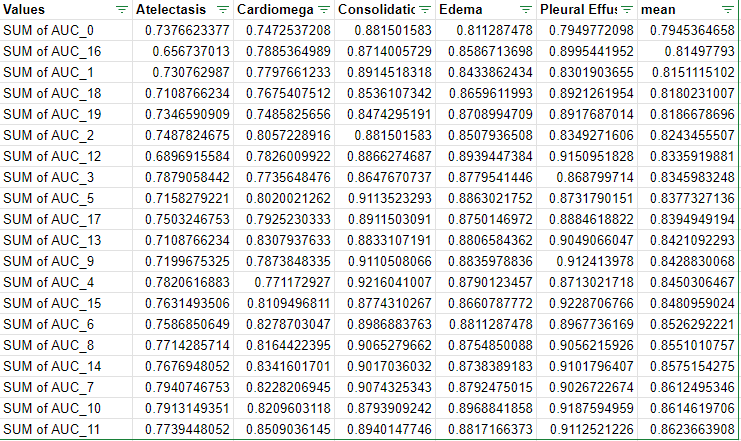

### U-Ones

Checkpoints: 7, 11, 10, 6, 8, 15, 12, 4, 5, 14

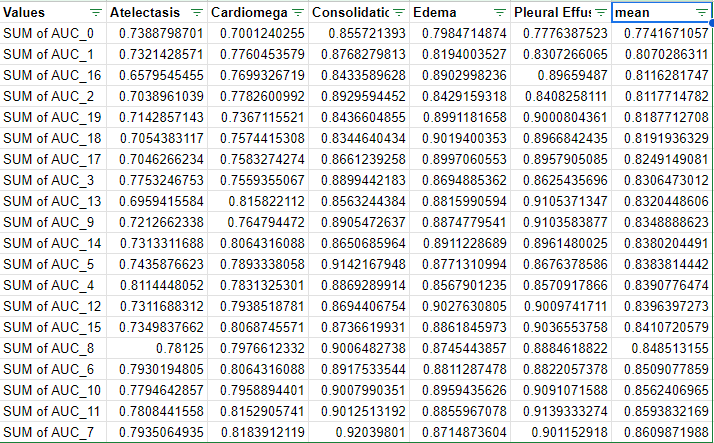

### U-Zeros

Checkpoints: 11, 8, 6, 14, 10, 5, 13, 7, 4, 9

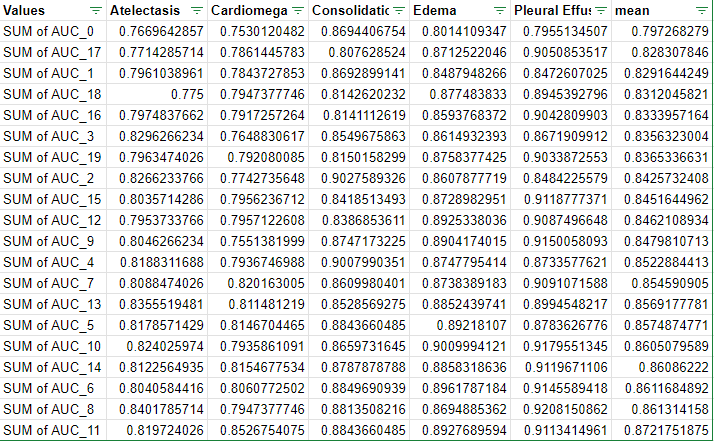

### U-MultiClass

Checkpoints: 11, 4, 10, 9, 15, 5, 13, 8, 6, 14

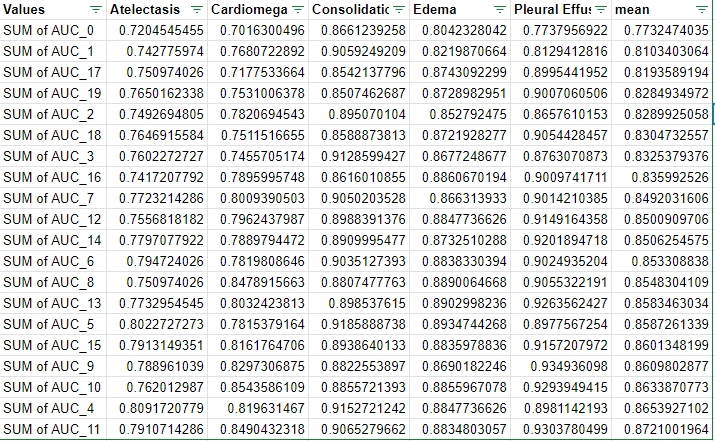

In [100]:
ckpts = [11, 10, 7, 14, 8, 6, 15, 4, 9, 13]
ignore_auc_score, ignore_pred = get_roc_score(ignore_results, model_name=[f'model_{id}' for id in ckpts])

ckpts = [7, 11, 10, 6, 8, 15, 12, 4, 5, 14]
ones_auc_score, ones_pred = get_roc_score(ones_results, model_name=[f'model_{id}' for id in ckpts])

ckpts = [11, 8, 6, 14, 10, 5, 13, 7, 4, 9]
zeros_auc_score, zeros_pred = get_roc_score(zeros_results,model_name=[f'model_{id}' for id in ckpts])

ckpts = [11, 4, 10, 9, 15, 5, 13, 8, 6, 14]
multi_auc_score, multi_pred = get_roc_score(multiclass_results, multiclass=True, model_name=[f'model_{id}' for id in ckpts])

c:\Users\hurbl\OneDrive\Área de Trabalho\Loon Factory\repository\Chest-X-Ray-Pathology-Classifier\.env\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
c:\Users\hurbl\OneDrive\Área de Trabalho\Loon Factory\repository\Chest-X-Ray-Pathology-Classifier\.env\Lib\site-packages\sklearn\utils\validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
c:\Users\hurbl\OneDrive\Área de Trabalho\Loon Factory\repository\Chest-X-Ray-Pathology-Classifier\.env\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
c:\Users\hurbl\OneDrive\Á

Calculate confidence interval

In [114]:
import compare_auc_delong_xu
import importlib
importlib.reload(compare_auc_delong_xu)
from scipy import stats
import numpy as np

def get_intervals(labels, preds):
    alpha = .95

    auc, auc_cov = compare_auc_delong_xu.delong_roc_variance(
        labels,
        preds
    )

    auc_std = np.sqrt(auc_cov)
    lower_upper_q = np.abs(np.array([0, 1]) - (1 - alpha) / 2)

    ci = stats.norm.ppf(
        lower_upper_q,
        loc=auc,
        scale=auc_std)

    ci[ci > 1] = 1

    #print('AUC:', auc)
    #print('AUC COV:', auc_cov)
    #print('95% AUC CI:', ci)

    return auc, ci


In [119]:
res = pd.DataFrame(columns=pathologies, index=['mean_AUC', 'confidence_int'])
for pathology in pathologies:
    #print(pathology)
    auc, ci = get_intervals(
        ignore_results[('labels', pathology)].to_numpy(),
        ignore_pred[('Mean', pathology)].to_numpy()
    )
    res.loc[:, pathology] = [auc, ci]
res.to_csv('results/approach_result_ignore.csv')
res


,Atelectasis,Cardiomegaly,Consolidation,Edema,Pleural Effusion
mean_AUC,0.776867,0.83797,0.917835,0.886772,0.917866
confidence_int,"[0.7157083206277822, 0.838025445605984]","[0.781428909315534, 0.8945101410033887]","[0.8805736770452689, 0.955096457132328]","[0.8297296479767746, 0.9438153255681991]","[0.8798870222010027, 0.9558444998295628]"


In [120]:
res = pd.DataFrame(columns=pathologies, index=['mean_AUC', 'confidence_int'])
for pathology in pathologies:
    #print(pathology)
    auc, ci = get_intervals(
        ones_results[('labels', pathology)].to_numpy(),
        ones_pred[('Mean', pathology)].to_numpy()
    )
    res.loc[:, pathology] = [auc, ci]
res.to_csv('results/approach_result_ones.csv')
res

,Atelectasis,Cardiomegaly,Consolidation,Edema,Pleural Effusion
mean_AUC,0.77987,0.826807,0.907885,0.895003,0.905175
confidence_int,"[0.7195630435912608, 0.8401772161489991]","[0.7686851170016146, 0.8849293408297106]","[0.8661816080017655, 0.9495880286633938]","[0.8425960474051254, 0.9474098314896425]","[0.8636538674044676, 0.9466955829485579]"


In [121]:
res = pd.DataFrame(columns=pathologies, index=['mean_AUC', 'confidence_int'])
for pathology in pathologies:
    #print(pathology)
    auc, ci = get_intervals(
        zeros_results[('labels', pathology)].to_numpy(),
        zeros_pred[('Mean', pathology)].to_numpy()
    )
    res.loc[:, pathology] = [auc, ci]
res.to_csv('results/approach_result_zeros.csv')
res

,Atelectasis,Cardiomegaly,Consolidation,Edema,Pleural Effusion
mean_AUC,0.831981,0.827605,0.881954,0.895356,0.920011
confidence_int,"[0.7783363943706046, 0.8856246445904344]","[0.7674089413181949, 0.8878001302622444]","[0.8355020723457488, 0.928405661711239]","[0.8397670382236666, 0.9509443080432356]","[0.8823466717099017, 0.9576747779281355]"


In [124]:
res = pd.DataFrame(columns=pathologies, index=['mean_AUC', 'confidence_int'])
for pathology in pathologies:
    #print(pathology)
    auc, ci = get_intervals(
        multiclass_results[('labels', f'pos_{pathology}')].to_numpy(),
        multi_pred[('Mean', pathology)].to_numpy()
    )
    res.loc[:, pathology] = [auc, ci]
res.to_csv('results/approach_result_multiclass.csv')
res

,Atelectasis,Cardiomegaly,Consolidation,Edema,Pleural Effusion
mean_AUC,0.79651,0.83797,0.909392,0.890417,0.927518
confidence_int,"[0.7386962921324968, 0.8543231883869836]","[0.7801184147617274, 0.8958206355571953]","[0.8673705483012074, 0.9514143152597753]","[0.8357643579882423, 0.945070445068783]","[0.8931363570778822, 0.961899839186306]"
